In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import datetime   # package that helps manipulate dates
import matplotlib.dates as mdates
import calendar

from dateutil.parser import parse     # package for date parsing
from prophet import Prophet
from pmdarima import auto_arima




# Preprocessing data from AQICN and NASA

## AQICN data

If you’re working with data from aqicn.org, you need to run this code before using `rolling_prophet_forecast_CI_with_arima`. This step converts the AQICN data into a format compatible with `rolling_prophet_forecast_CI_with_arima`.

In [2]:
def change_df (df):
    data = df.copy()
    data.date = pd.to_datetime(data.date) #change date column into datetime format
    data = data.sort_values(by ='date', ascending= False) #sorting values in terms of datetime

    data.columns = ['date','PM25','PM10','O3','NO2','SO2','CO'] # The column names in the AQICN data are not user-friendly, so we need to rename them.

    # We need to drop missing values and convert all columns except the date column to numeric data types.
    for col in data.columns:
        if col != 'date':
            data[col] = pd.to_numeric(data[col], errors ='coerce')
    data = data.dropna()
    data = data.sort_values('date', ascending =False)
    return data


#Example
#

## Nasa data

If you’re working with data from NASA, you need to run this code before using rolling_prophet_forecast_CI_with_arima.
This step converts the NASA data into a format compatible with rolling_prophet_forecast_CI_with_arima.

NASA data sometimes includes so-called "fill-in" values. When the satellite is unable to detect air pollutants, it records certain fixed negative values for those dates. These values should be removed, and the code below will also filter out those rows.

In [3]:
def cleaning_NASA_data(a, pollutant):
    """
    Cleans NASA CSV data:
    - Renames columns
    - Drops unnecessary metadata rows
    - Converts columns to numeric types
    - Sorts by date
    - Filters for positive values of the pollutant (to remove fill-in or invalid values)
    """
    a.columns = ['date', pollutant]
    a.drop(list(range(0, 7)), inplace=True)  # drop first 7 metadata rows; adjust as needed
    a[pollutant] = pd.to_numeric(a[pollutant], errors='coerce')
    a['date'] = pd.to_datetime(a['date'])
    a = a.sort_values('date')
    a = a[a[pollutant] > 0]
    a = a.reset_index(drop=True)
    return a

## Aggregating data

The `make_agg` function takes a time series DataFrame and aggregates the pollutant data to the desired frequency—daily, weekly, or monthly—returning the mean value for each period.



In [4]:
def make_agg(df, freq='D', pollutant='NO2'):
    df_agg = df.copy()
    df_agg['date'] = pd.to_datetime(df_agg['date'])
    if freq == 'D':
        df_agg = df_agg[['date', pollutant]]
        return df_agg.rename(columns={pollutant:  pollutant})
    elif freq == 'W':
        df_agg['date'] = df_agg['date'].dt.to_period('W').dt.start_time
        result = df_agg.groupby('date')[pollutant].mean().reset_index()
        return result.rename(columns={pollutant:  pollutant})
    elif freq == 'M':
        df_agg['date'] = df_agg['date'].dt.to_period('M').dt.start_time
        result = df_agg.groupby('date')[pollutant].mean().reset_index()
        return result.rename(columns={pollutant:  pollutant })
    else:
        raise ValueError("freq must be 'D', 'W', or 'M'")

# Prophet + ARIMA

## Explanation of model:
The model consists of three main steps:
1. Apply a rolling window approach with Prophet to model the trend and seasonality.
2. Apply auto-ARIMA to the residuals from the first step to capture any remaining structure.
3. Identify anomalies using the residuals from the second step. (This process is repeated for daily, weekly, and monthly data.)

The main purpose of this approach is to obtain residuals that are not explained by any underlying structure—in other words, residuals that resemble white noise.
In practice, this means that if new data are affected by a regime change or a structural shift, our model will detect them as anomalies. Since our model is designed so that the residuals have no remaining structure, any new data that exhibit systematic changes will stand out as anomalies.

Of course, the ability to detect anomalies depends on how the regime change occurs—whether it is a gradual shift or an abrupt change lasting only a few days. To account for different types of structural changes, we apply this process to daily, weekly, and monthly data.

## Reason for usage of each modules:

### Prophet
We use Prophet because our data has two important characteristics:
1. Multiseasonality
2. Missing values

Prophet is well suited to handle multiseasonal patterns and missing data. However, it is not particularly effective at detecting regime changes or abrupt trend shifts, since it uses fixed changepoints to model trends. For this reason, we apply Prophet in a rolling window fashion, which improves its ability to capture local trend changes.

### Rolling window
1. Allows the model to focus on more recent data
2. Improves the detection of changepoints

By adopting a rolling window approach with Prophet, we can better reflect the latest changes in the data. However, given the size of our dataset, there is a limit to how small the training set can be, which still makes it challenging to detect sudden trend changes. Additionally, if there is a regime or structural change, its effect on air pollution may persist for some time, leading to autocorrelation in the residuals. To address this, we use auto-ARIMA to further remove any remaining structure.

### ARIMA
1. To remove any remaining autocorrelated structure in the residuals
2. Because air pollution data often exhibit autocorrelation

## Basic explanation of each input:

1. df: Dataframe which is preprocessed by using change_df, cleaning_NASA_data, or make_agg
2. pollutant: The column name for the pollutant.
3. train_steps: The number of time steps to use as the training set in each rolling window.
4. test_steps: The number of time steps to use as the test set.
5. step: The size of the shift for each window (how much the window moves forward each iteration).
6. z_thresh: The threshold(in standard deviations) for identifying anomalies in the final residuals.
7. freq: The data frequency 'D' for daily, 'W' for weekly, 'M' for monthly

## Code explanation:

1. Rename the columns for compatibility with Prophet.
2. Apply a rolling window: for each window, use Prophet to generate predicted pollutant values for the test set (`results['prophet_pred']`).
3. Calculate residuals as the difference between observed values and Prophet predictions (`results_df['residual'] = results['real'] - results['prophet_pred']`).
4. Fit an auto-ARIMA model to the residuals from step 3 to capture any remaining structure (`arima_pred`).
5. Compute the final prediction by adding the ARIMA correction to the Prophet prediction (`results['prophet_pred'] + arima_pred`).
6. Calculate the final residuals, z-scores, and identify outliers using the observed values and the final predictions. (We use z_thresh when we want to identify outliers)

In [5]:
from pmdarima import auto_arima

def rolling_prophet_forecast_CI_with_arima(
    df, pollutant='no2', train_steps=730, test_steps=30, step=30, z_thresh=3, freq='D'
):
    #  Rename the columns for compatibility with Prophet.
    df = df.sort_values('date').reset_index(drop=True)
    df_prophet = df.rename(columns={'date':'ds', pollutant:'y'})[['ds','y']].dropna()
    results = []
    """
    Apply a rolling window: for each window, use Prophet to generate predicted pollutant values for the test set
    """
    for train_end in range(train_steps, len(df_prophet)-test_steps+1, step):
        train = df_prophet.iloc[train_end-train_steps:train_end]
        test  = df_prophet.iloc[train_end:train_end+test_steps]
        m = Prophet(yearly_seasonality=True, weekly_seasonality=(freq!='M'), daily_seasonality=(freq=='D'))
        m.fit(train)
        fcst = m.predict(test[['ds']])
        pred = fcst['yhat'].values
        y_true = test['y'].values
        for i in range(len(pred)):
            results.append({
                'ds': test['ds'].values[i],
                'real': y_true[i],
                'prophet_pred': pred[i]
            })
        del m

    results_df = pd.DataFrame(results)
    results_df = results_df.drop_duplicates(subset=['ds'])
    
    # Calculate residuals as the difference between observed values and Prophet predictions
    results_df['residual'] = results_df['real'] - results_df['prophet_pred']
    
    # Fit an auto-ARIMA model to the residuals from step 3 to capture any remaining structure
    arima_mod = auto_arima(results_df['residual'].values, seasonal=False, suppress_warnings=True, stepwise=True, error_action='ignore')
    arima_pred = arima_mod.predict_in_sample()
    results_df['arima_correction'] = arima_pred
    
    #Compute the final prediction by adding the ARIMA correction to the Prophet prediction
    results_df['final_pred'] = results_df['prophet_pred'] + arima_pred

    #Calculate the final residuals, z-scores, and identify outliers using the observed values and the final predictions.
    results_df['arima_residual'] = results_df['real'] - results_df['final_pred']
    sigma = results_df['arima_residual'].std()
    results_df['zscore'] = results_df['arima_residual'] / sigma if sigma > 0 else 0
    results_df['outlier'] = np.abs(results_df['zscore']) > z_thresh
    return results_df



# Plotting the result of `rolling_prophet_forecast_CI_with_arima`

## Basic explanation of each input:
1. results_df: The output DataFrame from `rolling_prophet_forecast_CI_with_arima`
2. pollutant: The name of the pollutant to display on the plot.
3. shading_k: The number of standard deviations (k) used to shade the confidence interval region.
4. freq: The data frequency 'D' for daily, 'W' for weekly, 'M' for monthly

In [6]:
def plot_arima_anomaly_band(results_df, pollutant='NO2', shading_k=3, z_thresh=3, freq='D'):
    """
    results_df: DataFrame with columns ['ds', 'real', 'final_pred', 'arima_residual', 'outlier']
    """
    sigma = results_df['arima_residual'].std()
    
    # confidence interval
    lower = results_df['final_pred'] - shading_k * sigma
    upper = results_df['final_pred'] + shading_k * sigma

    
    #Plotting the results_df
    """
    gray = observed value
    blue = predicted value of rolling_prophet_forecast_CI_with_arima
    skyblue = confidence interval
    red dots = outlier(= anomaly)
    """
    plt.figure(figsize=(15,5))
    plt.plot(results_df['ds'], results_df['real'], color='orange', label='Observed')
    plt.plot(results_df['ds'], results_df['final_pred'], color='blue', label='Prophet(rolling)+ARIMA')
    plt.fill_between(results_df['ds'], lower, upper, color='skyblue', alpha=0.4, label=f'Prophet+ARIMA ±{shading_k}σ')
    plt.scatter(results_df.loc[results_df['outlier'], 'ds'],
                results_df.loc[results_df['outlier'], 'real'],
                color='red', s=32, label=f'Anomaly (|z|>{z_thresh})')
    plt.xlabel('Date'); plt.ylabel(pollutant.upper())
    plt.title(f'Prophet(rolling)+ARIMA: Prediction, Anomaly Band, Outlier [{freq}]')
    plt.legend(); plt.tight_layout(); plt.show()

# Residual diagnostics
Running ACF, PACF, and Ljung-Box test to check whether any temporal structure remains unexplained by the model.


## Basic explanation of each input:
1. res_df: The output DataFrame from `rolling_prophet_forecast_CI_with_arima`
2. lags: List of lags at which to calculate and display autocorrelation statistics and Ljung-Box test
3. title: Optional string, added to plot and print output for clarity. (e.g. Daily, Weekly, Monthly) 

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

def residual_diagnostics(res_df, lags=[10, 20, 30], title=''):
    resid = res_df['arima_residual'].values
    max_lags = min(max(lags), len(resid)//2 - 1)  
    lags_to_use = [lag for lag in lags if lag <= max_lags]
    
    import matplotlib.pyplot as plt
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.stats.diagnostic import acorr_ljungbox

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plot_acf(resid, lags=max_lags, zero=False, ax=plt.gca())
    plt.title(f'ACF {title}')
    plt.subplot(1,2,2)
    plot_pacf(resid, lags=max_lags, zero=False, ax=plt.gca())
    plt.title(f'PACF {title}')
    plt.tight_layout()
    plt.show()

    lb = acorr_ljungbox(resid, lags=lags_to_use, return_df=True)
    print(f'Ljung-Box Test {title} (using lags {lags_to_use}):\n{lb}\n')


# Example(Shanghai)

In [19]:
df_shi = pd.read_csv('data/aqicn/shanghai.csv')
df_shi = change_df(df_shi)

In [20]:
df_shi_weekly = make_agg(df_shi, freq='W', pollutant='NO2')
df_shi_monthly = make_agg(df_shi, freq='M', pollutant='NO2')

In [21]:
daily_shi = rolling_prophet_forecast_CI_with_arima(
    df_shi, pollutant='NO2', train_steps=730, test_steps=30, step=30, z_thresh=3, freq='D'
)

18:49:49 - cmdstanpy - INFO - Chain [1] start processing
18:49:49 - cmdstanpy - INFO - Chain [1] done processing
18:49:49 - cmdstanpy - INFO - Chain [1] start processing
18:49:49 - cmdstanpy - INFO - Chain [1] done processing
18:49:49 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:51 - cmdstanpy - INFO - Chain [1] done processing
18:49:51 - cmdstanpy - INFO - Chain [1] start processing
18:49:51 - cmdstanpy - INFO - Chain [1]

In [22]:
weekly_shi = rolling_prophet_forecast_CI_with_arima(
   df_shi_weekly, pollutant='NO2', train_steps=156, test_steps=8, step=4, z_thresh=3, freq='W'
)

18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing
18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing
18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing
18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing
18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing
18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing
18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing
18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing
18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1]

In [23]:
monthly_shi = rolling_prophet_forecast_CI_with_arima(
   df_shi_monthly, pollutant='NO2', train_steps=36, test_steps=4, step=1, z_thresh=3, freq='M'
)

18:50:34 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing
18:50:34 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing
18:50:34 - cmdstanpy - INFO - Chain [1] start processing
18:50:34 - cmdstanpy - INFO - Chain [1] done processing
18:50:35 - cmdstanpy - INFO - Chain [1] start processing
18:50:35 - cmdstanpy - INFO - Chain [1] done processing
18:50:35 - cmdstanpy - INFO - Chain [1] start processing
18:50:35 - cmdstanpy - INFO - Chain [1] done processing
18:50:35 - cmdstanpy - INFO - Chain [1] start processing
18:50:35 - cmdstanpy - INFO - Chain [1] done processing
18:50:35 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1] done processing
18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:36 - cmdstanpy - INFO - Chain [1]

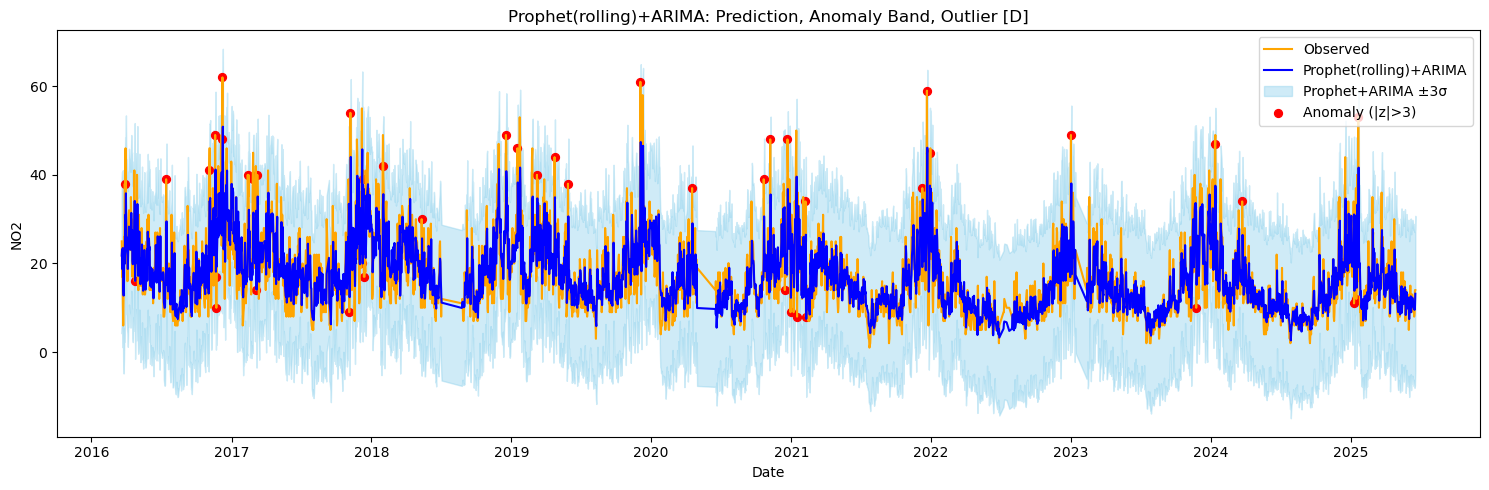

In [24]:
plot_arima_anomaly_band(daily_shi, pollutant='NO2', shading_k=3, z_thresh=3, freq='D')

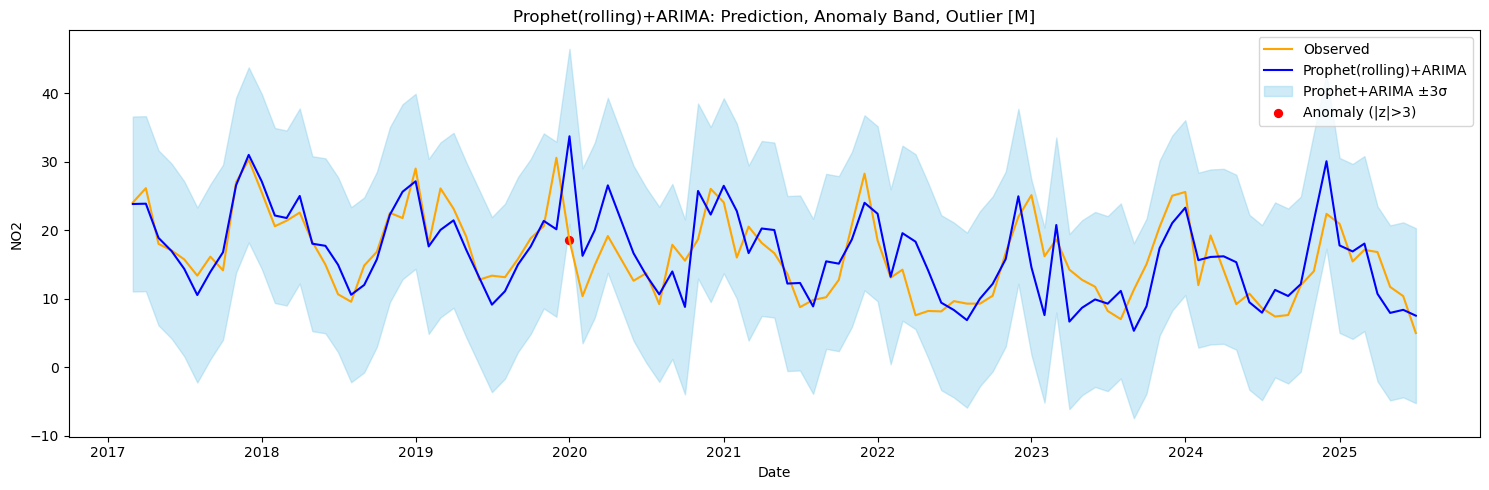

In [26]:
plot_arima_anomaly_band(monthly_shi, pollutant='NO2', shading_k=3, z_thresh=3, freq='M')

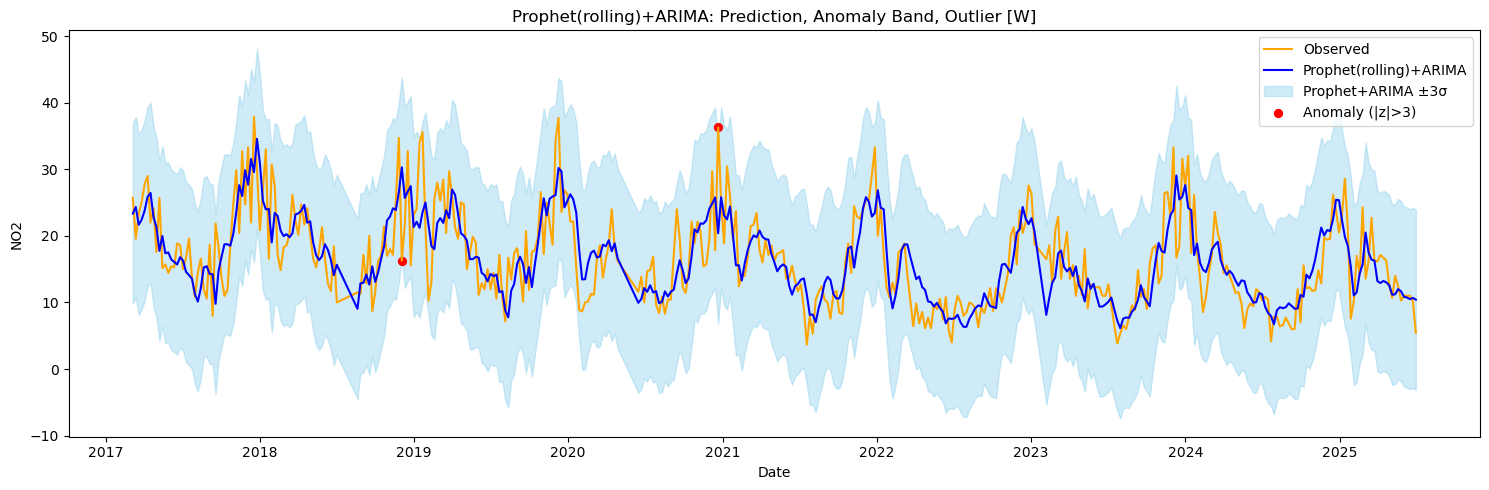

In [25]:
plot_arima_anomaly_band(weekly_shi, pollutant='NO2', shading_k=3, z_thresh=3, freq='W')

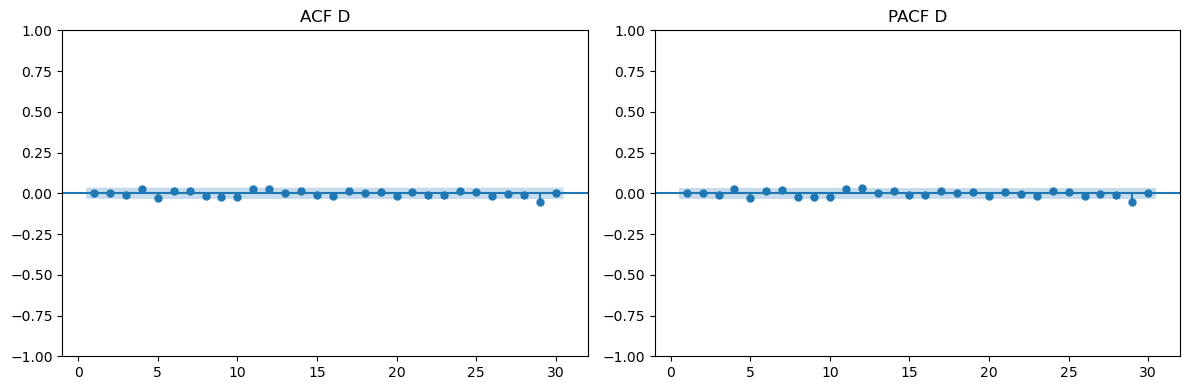

Ljung-Box Test D (using lags [10, 20, 30]):
      lb_stat  lb_pvalue
10  11.379538   0.328723
20  19.585668   0.484101
30  31.652730   0.383850



In [27]:
residual_diagnostics(daily_shi, lags=[10, 20, 30], title='D')

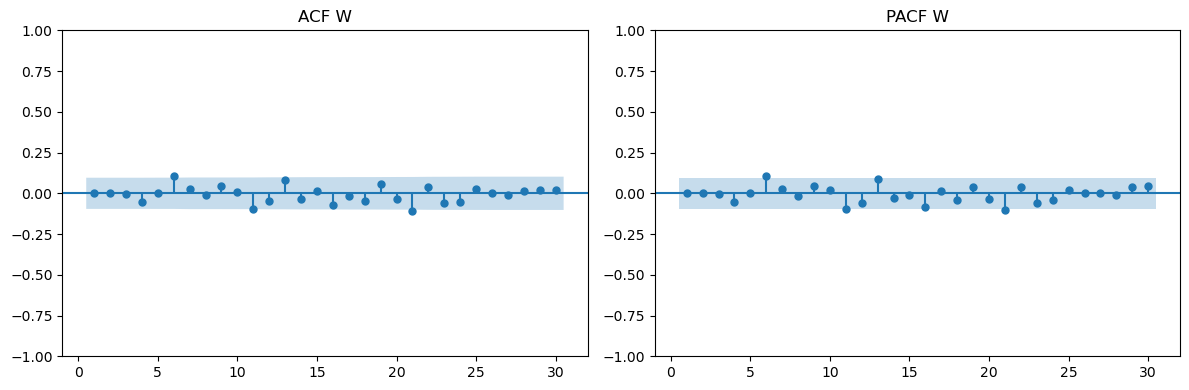

Ljung-Box Test W (using lags [10, 20, 30]):
      lb_stat  lb_pvalue
10   7.120338   0.714038
20  21.250957   0.382496
30  31.108523   0.410086



In [28]:
residual_diagnostics(weekly_shi, lags=[10, 20, 30], title='W')

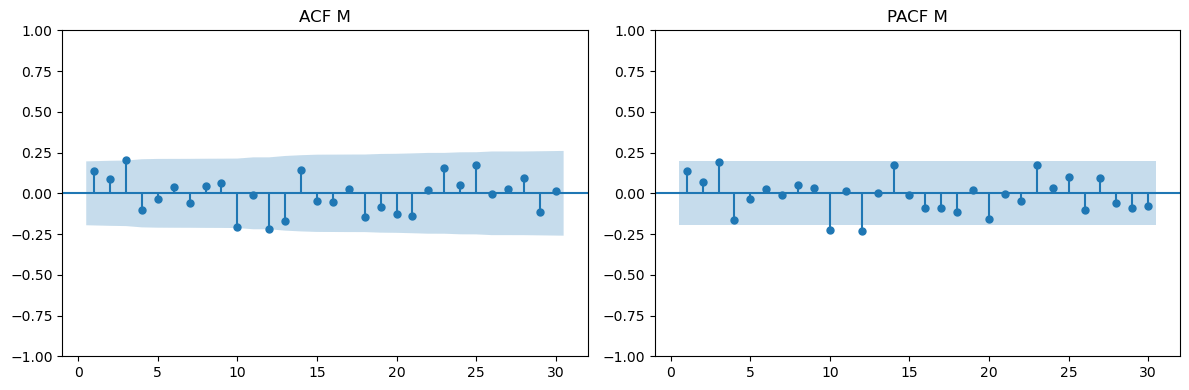

Ljung-Box Test M (using lags [10, 20, 30]):
      lb_stat  lb_pvalue
10  14.421968   0.154600
20  32.073303   0.042523
30  45.517749   0.034524



In [29]:
residual_diagnostics(monthly_shi, lags=[10, 20, 30], title='M')